In [1]:
import pathlib
import numpy as np
import pandas as pd
import datetime

import shapely.geometry

import netCDF4
import matplotlib.pyplot as plt
import matplotlib
cycle_colors = matplotlib.rc_params()['axes.prop_cycle'].by_key()['color']


In [2]:
path = pathlib.Path('~/src/sealevel/data/noaa/sst.mnmean.nc').expanduser()

geojson = {
  "type": "Polygon",
  "coordinates": [
    [
      [
        -2.3169684477848023,
        59.55038829477431
      ],
      [
        -2.3609137602848023,
        58.687705842609496
      ],
      [
        -1.3062262602848023,
        57.71521427970959
      ],
      [
        -0.9546637602848023,
        56.30365184743093
      ],
      [
        0.8031487397151977,
        53.65691670887463
      ],
      [
        1.9896721772151977,
        52.76213171841929
      ],
      [
        1.8138909272151977,
        51.54896999780882
      ],
      [
        3.0883049897151977,
        51.685400873692544
      ],
      [
        4.450609677215198,
        53.34324304348267
      ],
      [
        7.307054989715198,
        53.968273547881196
      ],
      [
        8.405687802215198,
        54.12308564468907
      ],
      [
        7.746508114715198,
        55.63969009356669
      ],
      [
        7.702562802215198,
        57.242714104018255
      ],
      [
        5.109789364715198,
        58.343441463911006
      ],
      [
        4.055101864715198,
        60.812168328822715
      ]
    ]
  ]
}
northsea = shapely.geometry.asShape(geojson)


In [3]:
with netCDF4.Dataset(path) as ds:
    sst = ds.variables['sst'][:]
    t = ds.variables['time'][:]
    t_units = ds.variables['time'].units
    lat = ds.variables['lat'][:]
    lon = ds.variables['lon'][:]
t = netCDF4.num2date(t, t_units)

In [4]:
northsea_idx = []
for j, k in np.ndindex(*sst.shape[1:]):
    pt = shapely.geometry.Point(lon[k], lat[j])
    if northsea.contains(pt):
        northsea_idx.append((j, k))
northsea_idx = np.array(northsea_idx)
northsea_sst = sst[:, northsea_idx[:, 0], northsea_idx[:, 1]]


In [5]:
df = pd.DataFrame(data=dict(
    time=t, 
    global_sst=sst.mean(axis=1).mean(axis=1),
    northsea_sst=northsea_sst.mean(axis=1)
)).set_index('time')

In [6]:
df.head()

,global_sst,northsea_sst
time,,
1854-01-01,13.204519,8.155829
1854-02-01,13.315591,6.131296
1854-03-01,13.393309,5.796405
1854-04-01,13.240363,6.666346
1854-05-01,13.228986,8.582175


Text(0.5,1,'Annual averaged sea surface temperature @ lat=50-56, lon=0-6')

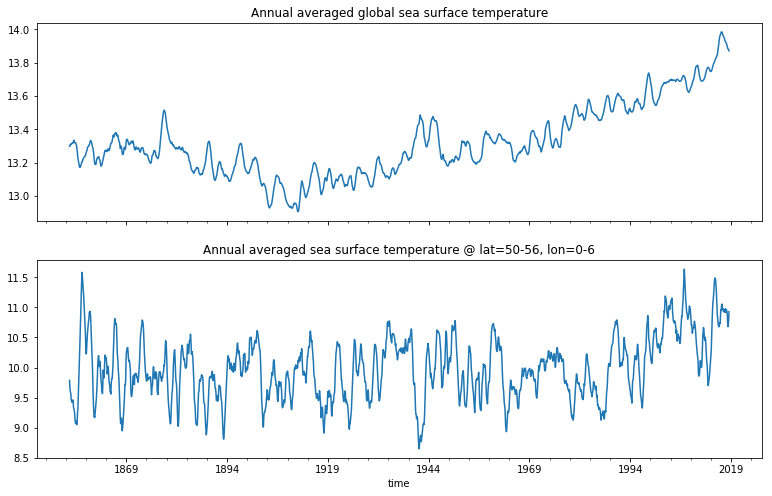

In [7]:
fig, axes = plt.subplots(figsize=(13, 8), nrows=2, sharex=True, sharey=False)
rolling_mean = df.rolling(12).agg('mean')
rolling_mean['global_sst'].plot(ax=axes[0])
axes[0].set_title('Annual averaged global sea surface temperature')
rolling_mean['northsea_sst'].plot(ax=axes[1])
axes[1].set_title('Annual averaged sea surface temperature @ lat=50-56, lon=0-6')


In [8]:
paths = list(pathlib.Path('~/src/sealevel/data/waterbase').expanduser().glob('id44-*.nc'))


In [9]:
sst_dfs = {}
for path in paths:
    ds = netCDF4.Dataset(path)
    t = netCDF4.num2date(ds.variables['time'][:], ds.variables['time'].units)
    sst = ds.variables['sea_water_temperature'][:]
    name = netCDF4.chartostring(ds.variables['platform_name'][:])[0]
    id_ = netCDF4.chartostring(ds.variables['platform_id'][:])[0]
    sst_df = pd.DataFrame(data=dict(t=np.squeeze(t), sst=np.squeeze(sst)))
    sst_df['id'] = str(id_)
    sst_df['name'] = name
    sst_dfs[id_] = sst_df

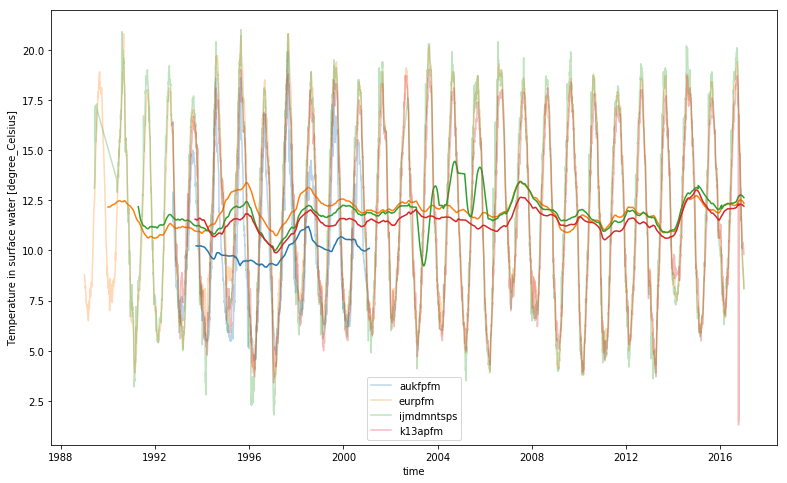

In [10]:
sst_df = pd.concat(sst_dfs)
fig, ax = plt.subplots(figsize=(13, 8))

for color, (id_, sst_df_i) in zip(cycle_colors, sst_dfs.items()):
    sst_df_i['sst_masked'] = np.ma.masked_outside(sst_df_i.sst, 0, 30)
    ax.plot(sst_df_i.t, np.ma.masked_outside(sst_df_i.sst, 0, 30), label=id_, color=color, alpha=0.3)
    ax.plot(sst_df_i.t, sst_df_i['sst_masked'].rolling(365).mean(), color=color, label='')
ax.set_xlabel('time')
ax.set_ylabel('%s [%s]' % (ds.variables['sea_water_temperature'].long_name, ds.variables['sea_water_temperature'].units))
plt.legend()

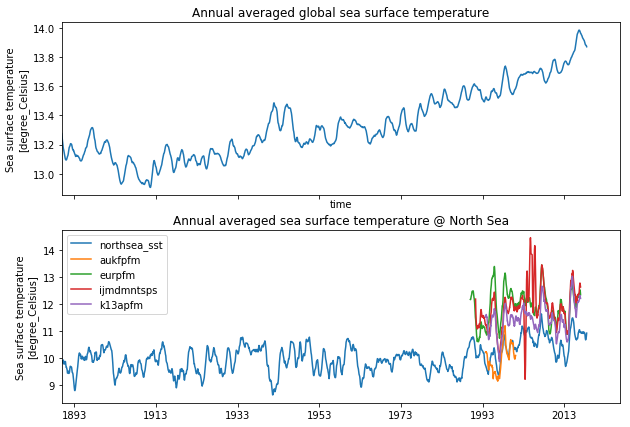

In [12]:
fig, axes = plt.subplots(figsize=(10, 7), nrows=2, sharex=True, sharey=False)
rolling_mean = df.rolling(12).agg('mean')
axes[0].plot(df.index, rolling_mean['global_sst'])
axes[0].set_title('Annual averaged global sea surface temperature')
axes[1].plot(df.index, rolling_mean['northsea_sst'])
axes[1].set_title('Annual averaged sea surface temperature @ North Sea')
for color, (id_, sst_df_i) in zip(cycle_colors[1:], sst_dfs.items()):
    sst_df_i['sst_masked'] = np.ma.masked_outside(sst_df_i.sst, 0, 30)
    axes[1].plot(sst_df_i.t, sst_df_i['sst_masked'].rolling(365).mean(), color=color, label=id_)
axes[0].set_xlabel('time')
axes[0].set_ylabel('%s\n[%s]' % ('Sea surface temperature', ds.variables['sea_water_temperature'].units))
axes[1].set_ylabel('%s\n[%s]' % ('Sea surface temperature', ds.variables['sea_water_temperature'].units))
axes[0].set_xlim(left=datetime.datetime(1890, 1, 1))
axes[1].legend()
fig.savefig('sea-surface-temperature.pdf')